In [76]:
import numpy as np
import pandas as pd
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.diagnostics import hpdi
import jax.numpy as jnp
import arviz as az
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [147]:
import geopandas as gpd

map_data = gpd.read_file('../../data/chadgeodata/geoBoundaries-TCD-ADM1-all/geoBoundaries-TCD-ADM1.geojson')
map_data = map_data.sort_values(by='shapeName')
map_data = map_data.reset_index(drop=True)
map_data.loc[16, 'shapeName'] = "N'Djamena"
data = pd.read_csv('../../data/panel_data.csv')
data = data.sort_values(by=['state', 'time'])
data = data.reset_index(drop=True)
data['longitude'] = [np.nan]*data.shape[0]
data['latitude'] = [np.nan]*data.shape[0]
data['region'] = [np.nan]*data.shape[0]
data

,time,state,t2m,tp,lai_hv,lai_lv,cases,deaths,longitude,latitude,region
0,2020-01-01,BAHR EL GAZEL,19.761659,0.001129,0.018409,0.660031,259.0,1.0,NaN,NaN,NaN
1,2020-02-01,BAHR EL GAZEL,21.966063,0.001508,0.018410,0.666643,165.0,0.0,NaN,NaN,NaN
2,2020-03-01,BAHR EL GAZEL,29.094683,0.000762,0.018419,0.672094,112.0,0.0,NaN,NaN,NaN
3,2020-04-01,BAHR EL GAZEL,32.909817,0.000761,0.018420,0.674704,160.0,1.0,NaN,NaN,NaN
4,2020-05-01,BAHR EL GAZEL,34.160160,0.006172,0.018420,0.676452,127.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1099,2023-08-01,WADI FIRA,28.563262,1.064246,0.276725,1.037876,3684.0,0.0,NaN,NaN,NaN
1100,2023-09-01,WADI FIRA,30.720729,0.231967,0.274975,0.979286,5681.0,0.0,NaN,NaN,NaN
1101,2023-10-01,WADI FIRA,30.087666,0.011532,0.271415,0.903648,5281.0,0.0,NaN,NaN,NaN
1102,2023-11-01,WADI FIRA,27.235060,0.000475,0.270037,0.882541,3310.0,0.0,NaN,NaN,NaN


In [148]:
longitudes, latitudes = [], []
for polygon in map_data['geometry'].values:
    centroid = polygon.centroid
    longitudes.append(centroid.x)
    latitudes.append(centroid.y)

for time in data['time'].unique():
    data.loc[data['time'] == time,'longitude'] = longitudes
    data.loc[data['time'] == time,'latitude'] = latitudes
    data.loc[data['time'] == time, 'region'] = list(range(23))

data

,time,state,t2m,tp,lai_hv,lai_lv,cases,deaths,longitude,latitude,region
0,2020-01-01,BAHR EL GAZEL,19.761659,0.001129,0.018409,0.660031,259.0,1.0,16.879392,14.550121,0.0
1,2020-02-01,BAHR EL GAZEL,21.966063,0.001508,0.018410,0.666643,165.0,0.0,16.879392,14.550121,0.0
2,2020-03-01,BAHR EL GAZEL,29.094683,0.000762,0.018419,0.672094,112.0,0.0,16.879392,14.550121,0.0
3,2020-04-01,BAHR EL GAZEL,32.909817,0.000761,0.018420,0.674704,160.0,1.0,16.879392,14.550121,0.0
4,2020-05-01,BAHR EL GAZEL,34.160160,0.006172,0.018420,0.676452,127.0,0.0,16.879392,14.550121,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1099,2023-08-01,WADI FIRA,28.563262,1.064246,0.276725,1.037876,3684.0,0.0,21.503831,15.029089,22.0
1100,2023-09-01,WADI FIRA,30.720729,0.231967,0.274975,0.979286,5681.0,0.0,21.503831,15.029089,22.0
1101,2023-10-01,WADI FIRA,30.087666,0.011532,0.271415,0.903648,5281.0,0.0,21.503831,15.029089,22.0
1102,2023-11-01,WADI FIRA,27.235060,0.000475,0.270037,0.882541,3310.0,0.0,21.503831,15.029089,22.0


In [149]:
data['time'] = pd.to_datetime(data['time'])
data['month'] = data['time'].dt.month
data['year'] = data['time'].dt.year
data['cases'] = data['cases'].astype(int)

data = data.sort_values(by=['state', 'time'])  # Ensure data is sorted
# data['lag_cases'] = data.groupby('state')['cases'].shift(1)
# data = data.dropna(subset=['lag_cases'])
# data = pd.get_dummies(data, columns=['state'], drop_first=False)
# states = [element.split('_')[1] for element in data.columns if element.startswith('state')]
data = data.reset_index(drop=True)
data = data[['t2m','tp','region','cases','time','longitude','latitude','month']]
data.head()

,t2m,tp,region,cases,time,longitude,latitude,month
0,19.761659,0.001129,0.0,259,2020-01-01,16.879392,14.550121,1
1,21.966063,0.001508,0.0,165,2020-02-01,16.879392,14.550121,2
2,29.094683,0.000762,0.0,112,2020-03-01,16.879392,14.550121,3
3,32.909817,0.000761,0.0,160,2020-04-01,16.879392,14.550121,4
4,34.160160,0.006172,0.0,127,2020-05-01,16.879392,14.550121,5


## Creating adjency matrix

In [202]:
# Create the adjacency matrix (NxN), where N is the number of regions
def compute_adjacency_matrix(data):
    W = np.zeros((len(data), len(data)))
    # Loop over each region and mark neighbors
    for i in range(len(data)):
        neighbors = data.iloc[i].geometry.touches(data.geometry)  # Find neighbors touching the region
        W[i, neighbors] = 1
    return W
W = compute_adjacency_matrix(map_data)
print(W)

[[0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.]
 [1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.

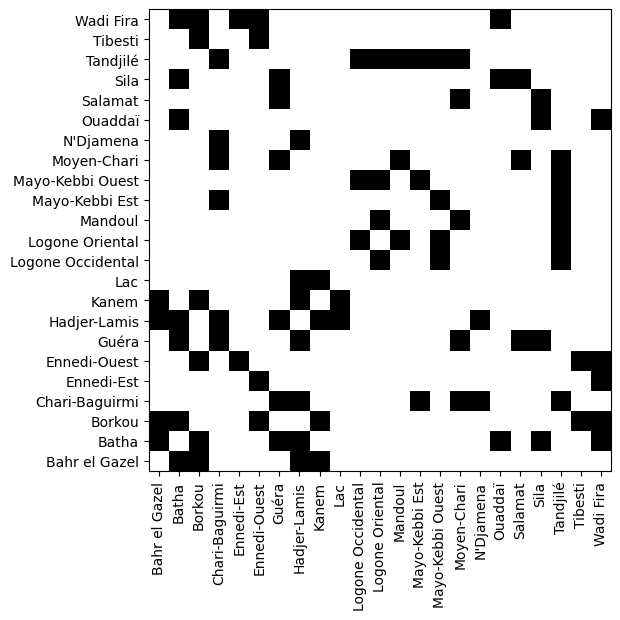

In [221]:
import networkx as nx
import matplotlib.pyplot as plt

states = map_data['shapeName'].unique().tolist()
plt.figure(figsize=(6, 6))
plt.imshow(W, cmap='binary', origin='lower')
# plt.xlabel('Region')
# plt.ylabel('Region')
plt.xticks(range(23), states, rotation=90)
plt.yticks(range(23), states, rotation=0)
plt.grid(False)
plt.show()

In [239]:
def adj_graph(gdf, size=(5,5), ttl='Adjacency Graph: toy data', plot=True):
    # create a empty graph
    nx_graph = nx.Graph()

    # add nodes with their coordinates and area names
    for idx, geometry in enumerate(gdf.geometry):
        centroid = geometry.centroid
        nx_graph.add_node(idx, pos=(centroid.x, centroid.y))

    adjacency_matrix = compute_adjacency_matrix(gdf)    

    # add edges based on adjacency
    for i, j in zip(*np.where(adjacency_matrix == 1)):
        nx_graph.add_edge(i, j)

    # visualize the graph with nodes aligned with actual locations and labeled with area names
        pos = nx.get_node_attributes(nx_graph, 'pos')

    if plot:
        fig, ax = plt.subplots(1, 1, figsize=size)
        nx.draw(nx_graph, pos=nx.spring_layout(nx_graph), with_labels=True, labels={i: gdf.iloc[i].shapeName for i in nx_graph.nodes()},
                node_size=1000, node_color="skyblue", font_size=8, font_color="black", ax=ax)
        plt.title(ttl)

    return nx_graph, pos

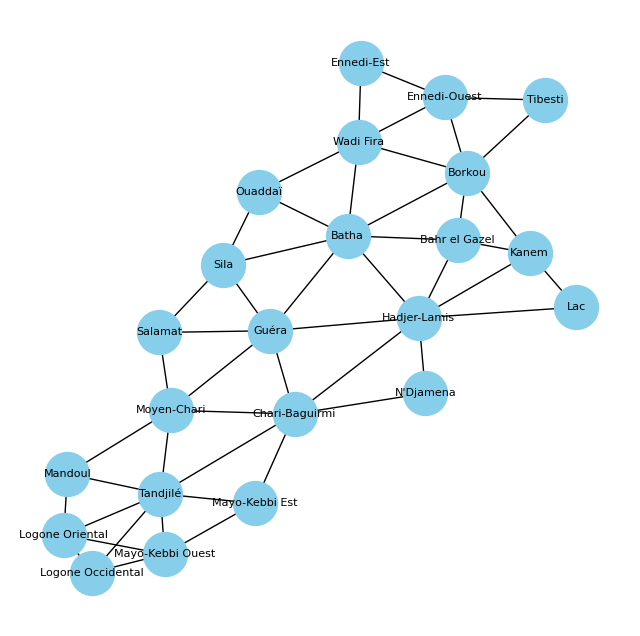

In [244]:
_,_ =adj_graph(map_data, size=(8,8), ttl='')
plt.show()

## Creating train and test sets

In [151]:
data_test = data[data['time']>'2023-06-01']
X_test = jnp.array(data_test[['t2m', 'tp','region','month','longitude','latitude']].values.tolist())
y_test = jnp.array(data_test['cases'].values.astype(int).tolist())

In [152]:
data_train = data[data['time']<='2023-06-01']
X_train = jnp.array(data_train[['t2m', 'tp','region','month','longitude','latitude']].values.tolist())
y_train = jnp.array(data_train['cases'].values.astype(int).tolist())

## Define the ICAR prior

The ICAR model assumes that the random effect for a given region is conditionally dependent on the random effects of neighboring regions. The prior for the spatial effect $\phi_i$ of region $i$ is modeled such that:

$$
\phi_i \mid \{\phi_j : j \neq i\} \sim \mathcal{N} \left( \frac{1}{N_i} \sum_{j \in N(i)} \phi_j, \tau^2 \right)
$$

Where:

* $N(i)$ are the neighbors of region $i$,
* $N_i$ is the number of neighbors of region $i$,
* $\tau^2$ is a scaling parameter (precision).

This induces a spatial dependence structure, as the random effect for each region depends on the mean of its neighbors.


In [214]:
def icar_prior(W, tau):
    """
    W: Adjacency matrix (NxN), where W[i,j] = 1 if regions i and j are neighbors.
    tau: Precision (inverse variance) for the spatial random effect.
    """
    N = W.shape[0]  # Number of regions
    D = jnp.diag(jnp.sum(W, axis=1))  # Degree matrix
    L = D - W  # Laplacian matrix
    
    # Add a small jitter to make the Laplacian invertible
    jitter = 1e-5 * jnp.eye(N)
    
    # ICAR prior: multivariate normal with precision matrix L (Laplacian)
    phi = numpyro.sample('phi', dist.MultivariateNormal(loc=jnp.zeros(N), precision_matrix=L + jitter))
    
    # Scale by tau (precision parameter)
    return tau * phi

## Define the Bayesian model incorporating ICAR prior

In [215]:
def malaria_model(X, W=W, y=None):
    # Priors for coefficients of continuous variables
    beta_t2m = numpyro.sample('beta_t2m', dist.Normal(25, 5.0))
    beta_tp = numpyro.sample('beta_tp', dist.Normal(0, 1.0))
    
    # Priors for sine and cosine coefficients (for periodicity)
    beta_sin_month = numpyro.sample('beta_sin_month', dist.Normal(0, 1.0))
    beta_cos_month = numpyro.sample('beta_cos_month', dist.Normal(0, 1.0))

    # Priors for spatial terms (longitude and latitude)
    beta_lon = numpyro.sample('beta_lon', dist.Normal(0, 1.0))
    beta_lat = numpyro.sample('beta_lat', dist.Normal(0, 1.0))

    # Model for the linear predictor
    mu_t2m = jnp.dot(X[:, 0], beta_t2m)      # Temperature effect
    mu_tp = jnp.dot(X[:, 1], beta_tp)       # Precipitation effect
    
    # Periodicity (seasonality) effect: using sine and cosine of the month
    sin_month = jnp.sin(2 * jnp.pi * X[:, 3] / 12)  # X[:, 3] is month
    cos_month = jnp.cos(2 * jnp.pi * X[:, 3] / 12)
    mu_sin_month = beta_sin_month * sin_month
    mu_cos_month = beta_cos_month * cos_month
    
    # Spatial effects: longitude and latitude
    mu_lon = jnp.dot(X[:, 4], beta_lon)  # X[:, 4] is longitude
    mu_lat = jnp.dot(X[:, 5], beta_lat)  # X[:, 5] is latitude
    
    # Prior for the spatial random effect (using ICAR)
    tau_phi = numpyro.sample('tau_phi', dist.HalfNormal(1.0))  # Precision for ICAR random effect
    phi = icar_prior(W, tau_phi)  # ICAR random effect
    
    # Random spatial effect by region (phi based on region index)
    mu_phi = phi[X[:, 2].astype(int)]  # X[:, 2] is the region index
    
    mu = jnp.exp(mu_t2m + mu_tp + mu_phi + mu_sin_month + mu_cos_month + mu_lon + mu_lat)  # Add spatial effect from phi

    # Combine all effects
    # mu = numpyro.deterministic('mu', jnp.abs(mu_t2m +mu_tp + mu_sin_month + mu_cos_month + mu_lon + mu_lat + mu_phi))
    
    # Likelihood (Poisson for malaria cases)
    numpyro.sample('obs', dist.Poisson(mu), obs=y)

## Run the MCMC simulation

In [245]:
# Run MCMC with the ICAR model
nuts_kernel = NUTS(malaria_model)
mcmc = MCMC(nuts_kernel, num_samples=5000, num_warmup=1000)
rng_key = random.PRNGKey(0)

# Example: W is the adjacency matrix, X_train has the features, y_train are the observed cases
mcmc.run(rng_key, X=X_train, W=W, y=y_train)
mcmc.print_summary()

sample: 100%|██████████| 6000/6000 [35:00<00:00,  2.86it/s, 1023 steps of size 3.22e-08. acc. prob=0.83]   



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
  beta_cos_month     -1.48      0.00     -1.48     -1.48     -1.48      0.50      1.00
        beta_lat     -1.13      0.00     -1.13     -1.13     -1.13      0.50      1.00
        beta_lon     -1.31      0.00     -1.31     -1.31     -1.31       nan       nan
  beta_sin_month      1.62      0.00      1.62      1.62      1.62      0.50      1.00
        beta_t2m      1.18      0.00      1.18      1.18      1.18      0.50      1.00
         beta_tp      0.99      0.00      0.99      0.99      0.99      0.50      1.00
          phi[0]      0.76      0.00      0.76      0.76      0.76      0.50      1.00
          phi[1]      1.13      0.00      1.13      1.13      1.13      0.50      1.00
          phi[2]      1.08      0.00      1.08      1.08      1.08      0.50      1.00
          phi[3]     -0.64      0.00     -0.64     -0.64     -0.64      0.50      1.00
          phi[4]     -1.03      0.00     -

## Old model

In [75]:
import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS
from jax import random

def panel_model(X, y=None):
     # Priors for coefficients
    beta_t2m = numpyro.sample('beta_t2m', dist.Normal(25, 5.0))
    beta_tp = numpyro.sample('beta_tp', dist.Normal(0, 1.0))
    beta_state = numpyro.sample('beta_state', dist.Normal(100, 10.0).expand([23]))
    beta_lag = numpyro.sample('beta_lag', dist.Normal(0, 1.0))
    
    # Priors for seasonal (sine/cosine) terms
    beta_sin = numpyro.sample('beta_sin', dist.Normal(0, 5.0))
    beta_cos = numpyro.sample('beta_cos', dist.Normal(0, 5.0))
    
    # Priors for spatial terms (latitude/longitude)
    beta_lat = numpyro.sample('beta_lat', dist.Normal(0, 1.0))
    beta_lon = numpyro.sample('beta_lon', dist.Normal(0, 1.0))
    
    # Linear combination
    mu_lag = jnp.dot(X[:, 0], beta_lag)
    mu_t2m = jnp.dot(X[:, 1], beta_t2m)
    mu_tp = jnp.dot(X[:, 2], beta_tp)
    mu_state = jnp.dot(X[:, 6:], beta_state)
    
    # Seasonality (sine/cosine of the month)
    month = X[:, 5]
    mu_seasonal = beta_sin * jnp.sin(2 * jnp.pi * month / 12) + beta_cos * jnp.cos(2 * jnp.pi * month / 12)
    
    # Spatial effects (latitude and longitude)
    lat = X[:, 4]
    lon = X[:, 3]
    mu_spatial = beta_lat * lat + beta_lon * lon
    
    # Total effect
    mu = numpyro.deterministic('mu', jnp.abs(mu_t2m + mu_tp  + mu_state + mu_lag + mu_seasonal + mu_spatial))
    
    # sigma
    # sigma = numpyro.sample('sigma', dist.HalfNormal(1.0))
    
    # Likelihood
    numpyro.sample('obs', dist.Poisson(mu), obs=y)
    # numpyro.sample('obs', dist.Normal(mu, sigma), obs=y) 

# Run MCMC to sample from the posterior
nuts_kernel = NUTS(panel_model)
mcmc = MCMC(nuts_kernel, num_samples=5_000, num_warmup=5_000)
rng_key = random.PRNGKey(0)

# Assuming you have the following data arrays:
# X_train: features (t2m, tp, etc.), lat_train: latitude, lon_train: longitude, month_train: month (in numerical form)
mcmc.run(rng_key, X=X_train, y=y_train)

# Summarize the results
mcmc.print_summary()

sample: 100%|██████████| 10000/10000 [18:56<00:00,  8.80it/s, 1023 steps of size 1.96e-03. acc. prob=0.84]



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta_cos   -288.38      1.94   -288.35   -291.54   -285.29   5908.22      1.00
      beta_lag      0.89      0.00      0.89      0.89      0.89   4023.57      1.00
      beta_lat    -11.38      0.57    -11.38    -12.30    -10.45   1702.91      1.00
      beta_lon     53.17      0.52     53.17     52.33     54.04   2187.39      1.00
      beta_sin   -160.19      1.17   -160.18   -162.07   -158.31   6266.69      1.00
 beta_state[0]     58.08      3.78     58.11     52.02     64.68   2793.60      1.00
 beta_state[1]     95.86      6.09     95.98     84.93    105.27   1697.84      1.00
 beta_state[2]     22.75      3.50     22.74     16.84     28.38   1764.02      1.00
 beta_state[3]    112.90      6.35    112.91    102.68    123.40   6436.71      1.00
 beta_state[4]   -348.63      4.63   -348.56   -356.50   -341.28   2823.34      1.00
 beta_state[5]   -152.09      3.60   -152.07   -157.91   -146.21

## Plot the malaria risk over regions

/tmp/ipykernel_34397/3017634954.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  map_data['shapeName'][21] = "N'Djamena"
/tmp/ipykernel_34397/3017634954.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

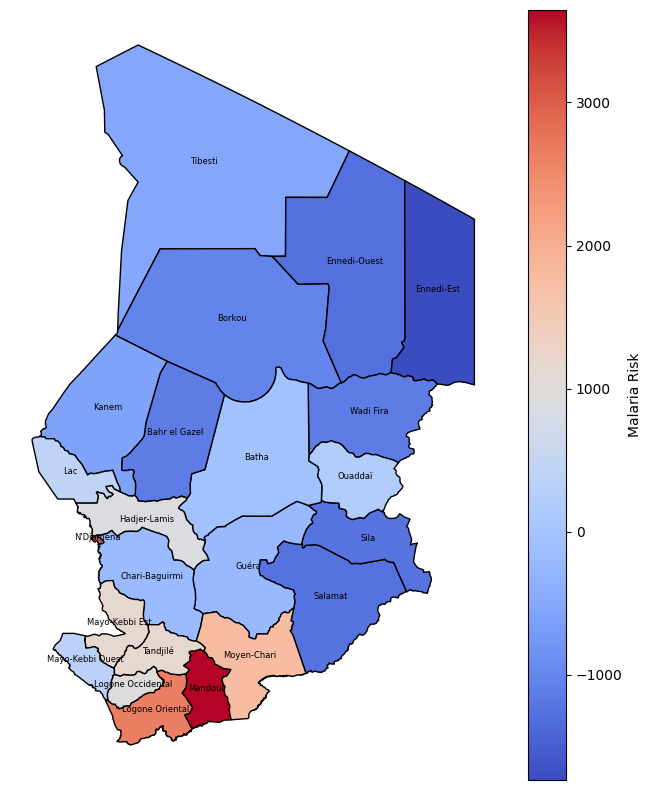

In [42]:
import cartopy.crs as ccrs
import geopandas as gpd

samples = mcmc.get_samples()
map_data = gpd.read_file('../../data/chadgeodata/geoBoundaries-TCD-ADM1-all/geoBoundaries-TCD-ADM1.geojson')
map_data['shapeName'][21] = "N'Djamena"
shape_names = map_data['shapeName'].tolist()
shape_names.sort()
map_data['risk'] = [None]*23
for element in shape_names:
    map_data.loc[map_data['shapeName']==element, 'risk'] = samples['beta_state'][:, shape_names.index(element)].mean()
map_data['risk'] = pd.to_numeric(map_data['risk'], errors='coerce')
fig, ax = plt.subplots(1, 1, figsize=(8, 10))

# ax = plt.axes(projection=ccrs.PlateCarree())
map_data.plot(edgecolor='black', column='risk', cmap='coolwarm', ax=ax, legend=True,
              legend_kwds={'label': "Malaria Risk", 'orientation': "vertical"})
for x, y, label in zip(map_data.geometry.centroid.x, map_data.geometry.centroid.y, map_data['shapeName']):
    ax.annotate(label, xy=(x, y), fontsize=6, ha='center')
plt.axis('off')
plt.savefig('../../docs/risk-scores.png', bbox_inches='tight', pad_inches=0.0)
plt.show()

## Convergences

/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to ha

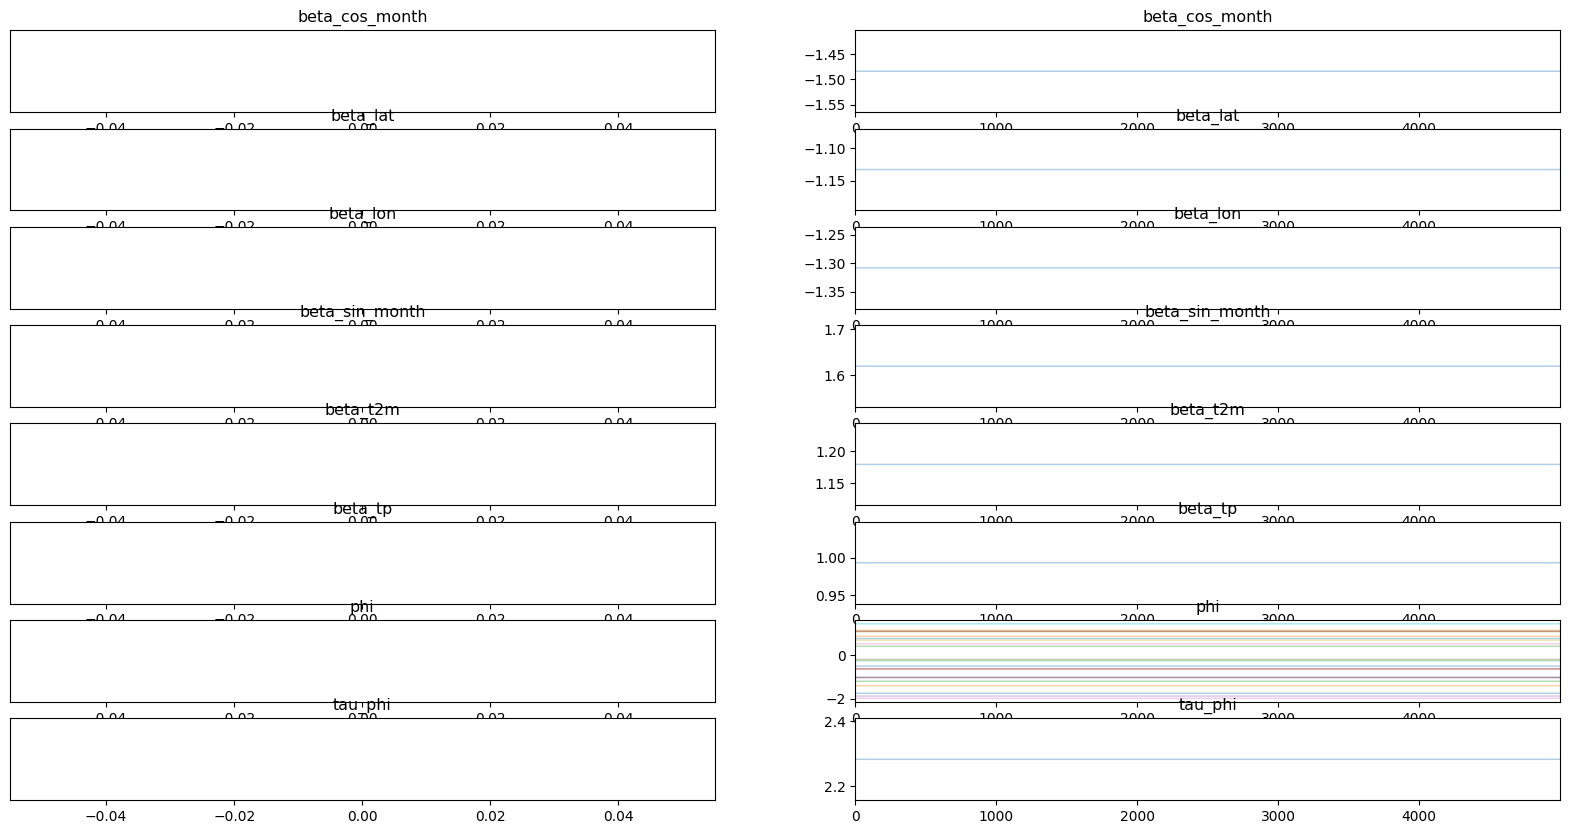

In [246]:
idata = az.from_numpyro(mcmc)
az.rcParams['plot.max_subplots'] = 200
az.plot_trace(idata, compact=True, figsize=(20,10), kind='trace')
# plt.savefig('../../docs/trace_plot.png', bbox_inches='tight', pad_inches=0.0)
plt.show()

## Calculate WAIC and LOO-CV

In [142]:
waic = az.waic(idata)
loo = az.loo(idata)

print('WAIC:', waic)
print('LOO-CV:', loo)

WAIC: Computed from 5000 posterior samples and 966 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -4446244.18  266447.25
p_waic      137.74        -

There has been a warning during the calculation. Please check the results.
LOO-CV: Computed from 5000 posterior samples and 966 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -4446106.45  266431.24
p_loo       -0.00        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)        0    0.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)  966  100.0%



/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/arviz/stats/stats.py:1647: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/beria/Documents/malaria-project/venv/lib/python3.12/site-packages/arviz/stats/stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


## Pred vs. original

In [247]:
def predict(X, model, key):
    _, rng_key_ = random.split(key)
    samples = model.get_samples()
    predictive = Predictive(malaria_model, samples)
    posterior_predictions = predictive(rng_key_, X=X)
    post_obs = posterior_predictions['obs']
    mean_post_pred = jnp.mean(post_obs, axis=0)
    hpdi_post_pred = hpdi(post_obs, 0.95)
    
    return mean_post_pred, hpdi_post_pred

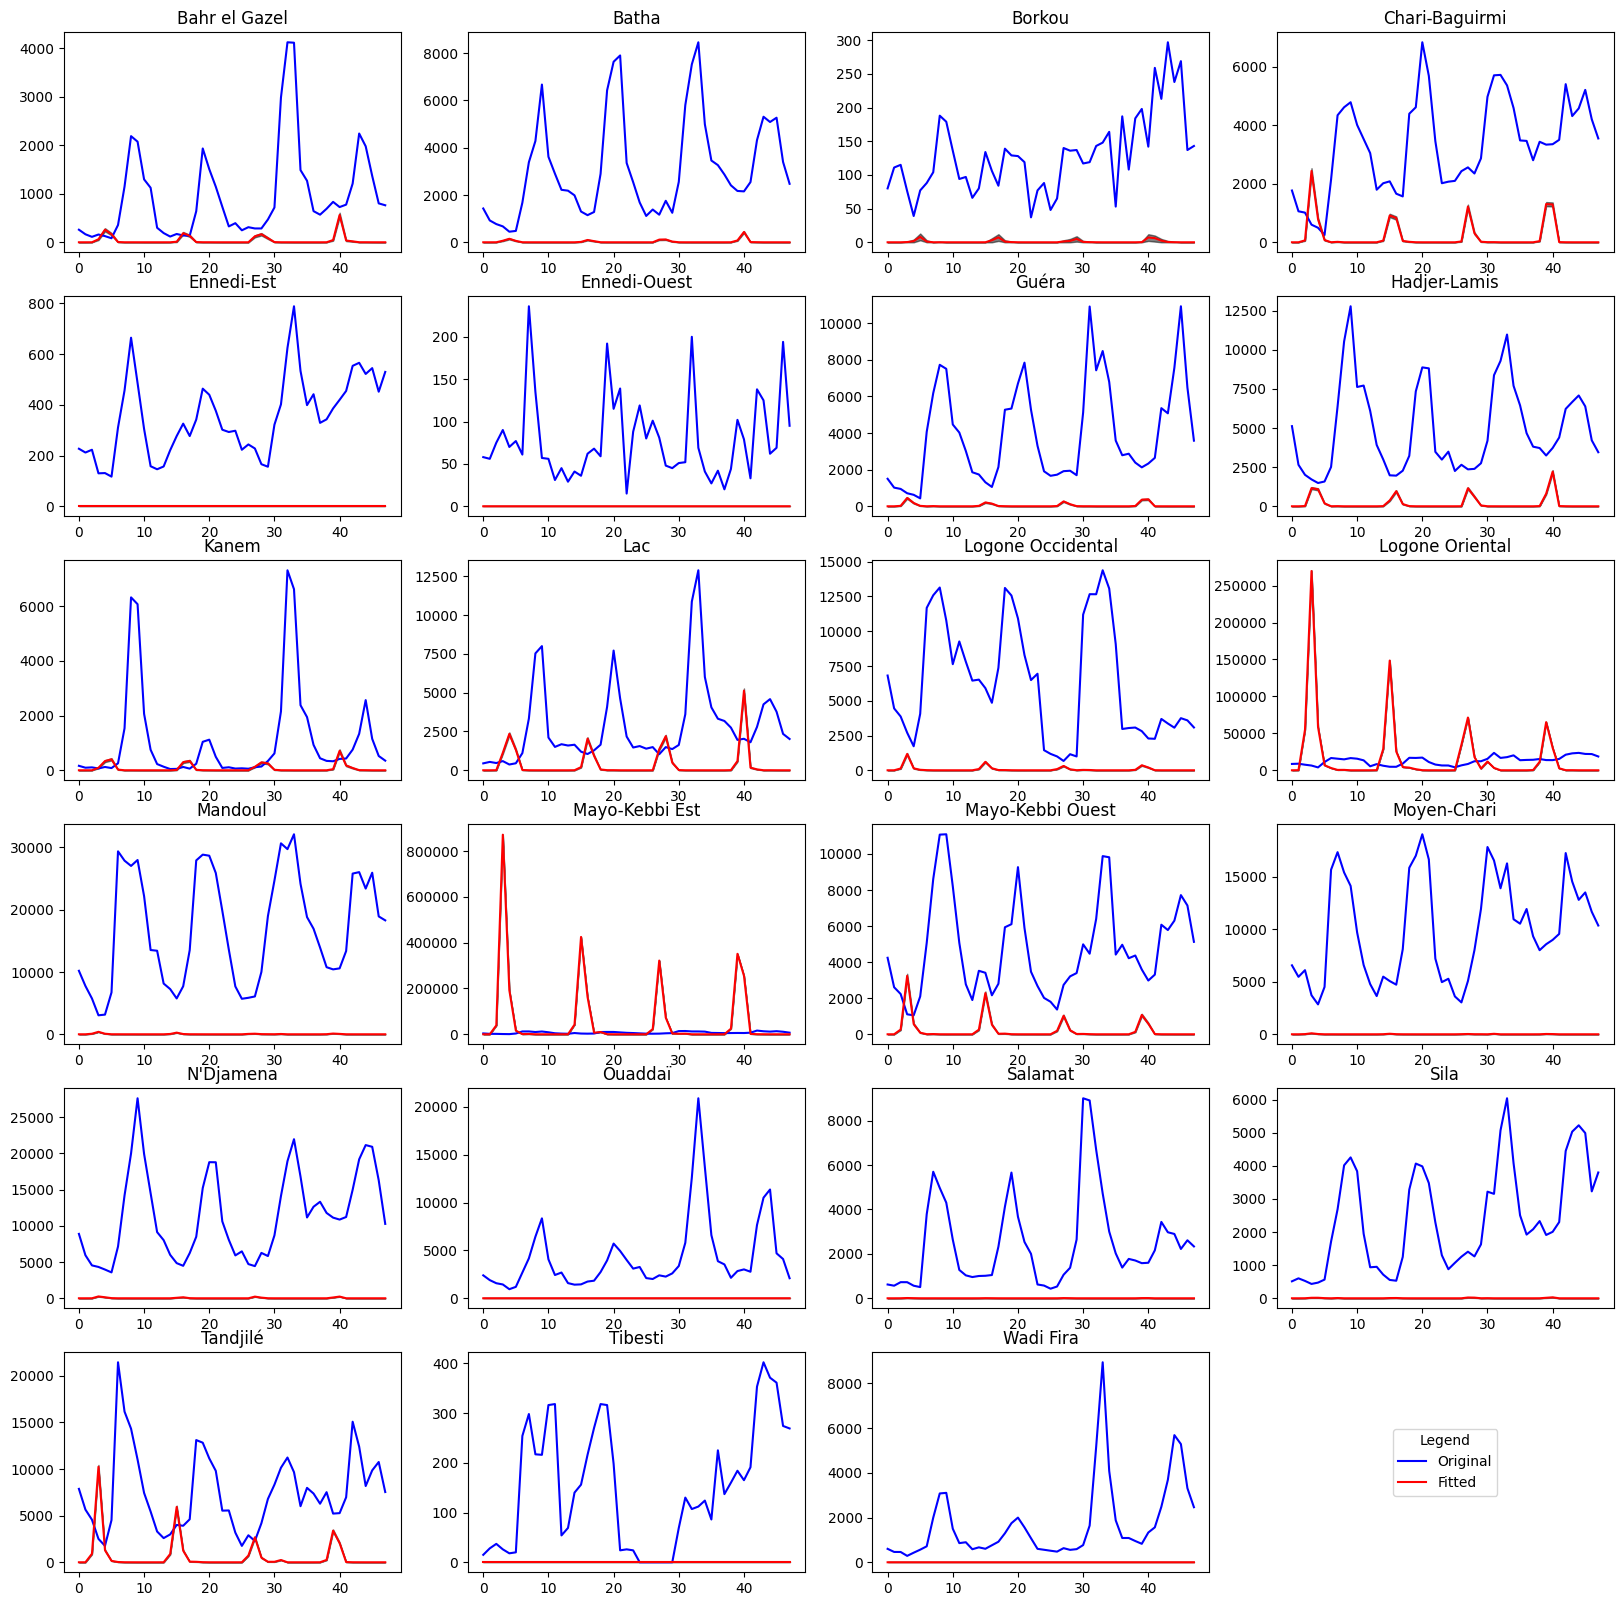

In [248]:
X = jnp.array(data[['t2m', 'tp','region','month','longitude','latitude']].values.tolist())
y = jnp.array(data['cases'].values.astype(int).tolist())
states = map_data['shapeName'].unique().tolist()

fig, axes = plt.subplots(6,4, figsize=(20,20))
xticks = range(48)
for i in range(23):
    idx = i // 4
    idy = i % 4
    mean_post_pred, hpdi_post_pred = predict(X[X[:,2]==i], mcmc, rng_key)
    axes[idx,idy].plot(y[X[:,2]==i], label='Original', color='blue')
    axes[idx,idy].plot(mean_post_pred, label='Fitted', color='red')
    axes[idx,idy].fill_between(xticks, hpdi_post_pred[0], hpdi_post_pred[1], color='black', alpha=0.5)
    axes[idx,idy].set_title(states[i])

axes[5, 3].clear()
axes[5, 3].axis('off')
handles, labels = axes[0, 0].get_legend_handles_labels()  # Get handles and labels from the first subplot
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, 0.5), bbox_transform=axes[5, 3].transAxes, title='Legend')

# plt.savefig('../../docs/predictions.png', bbox_inches='tight', pad_inches=0.0)

## Residuals plot

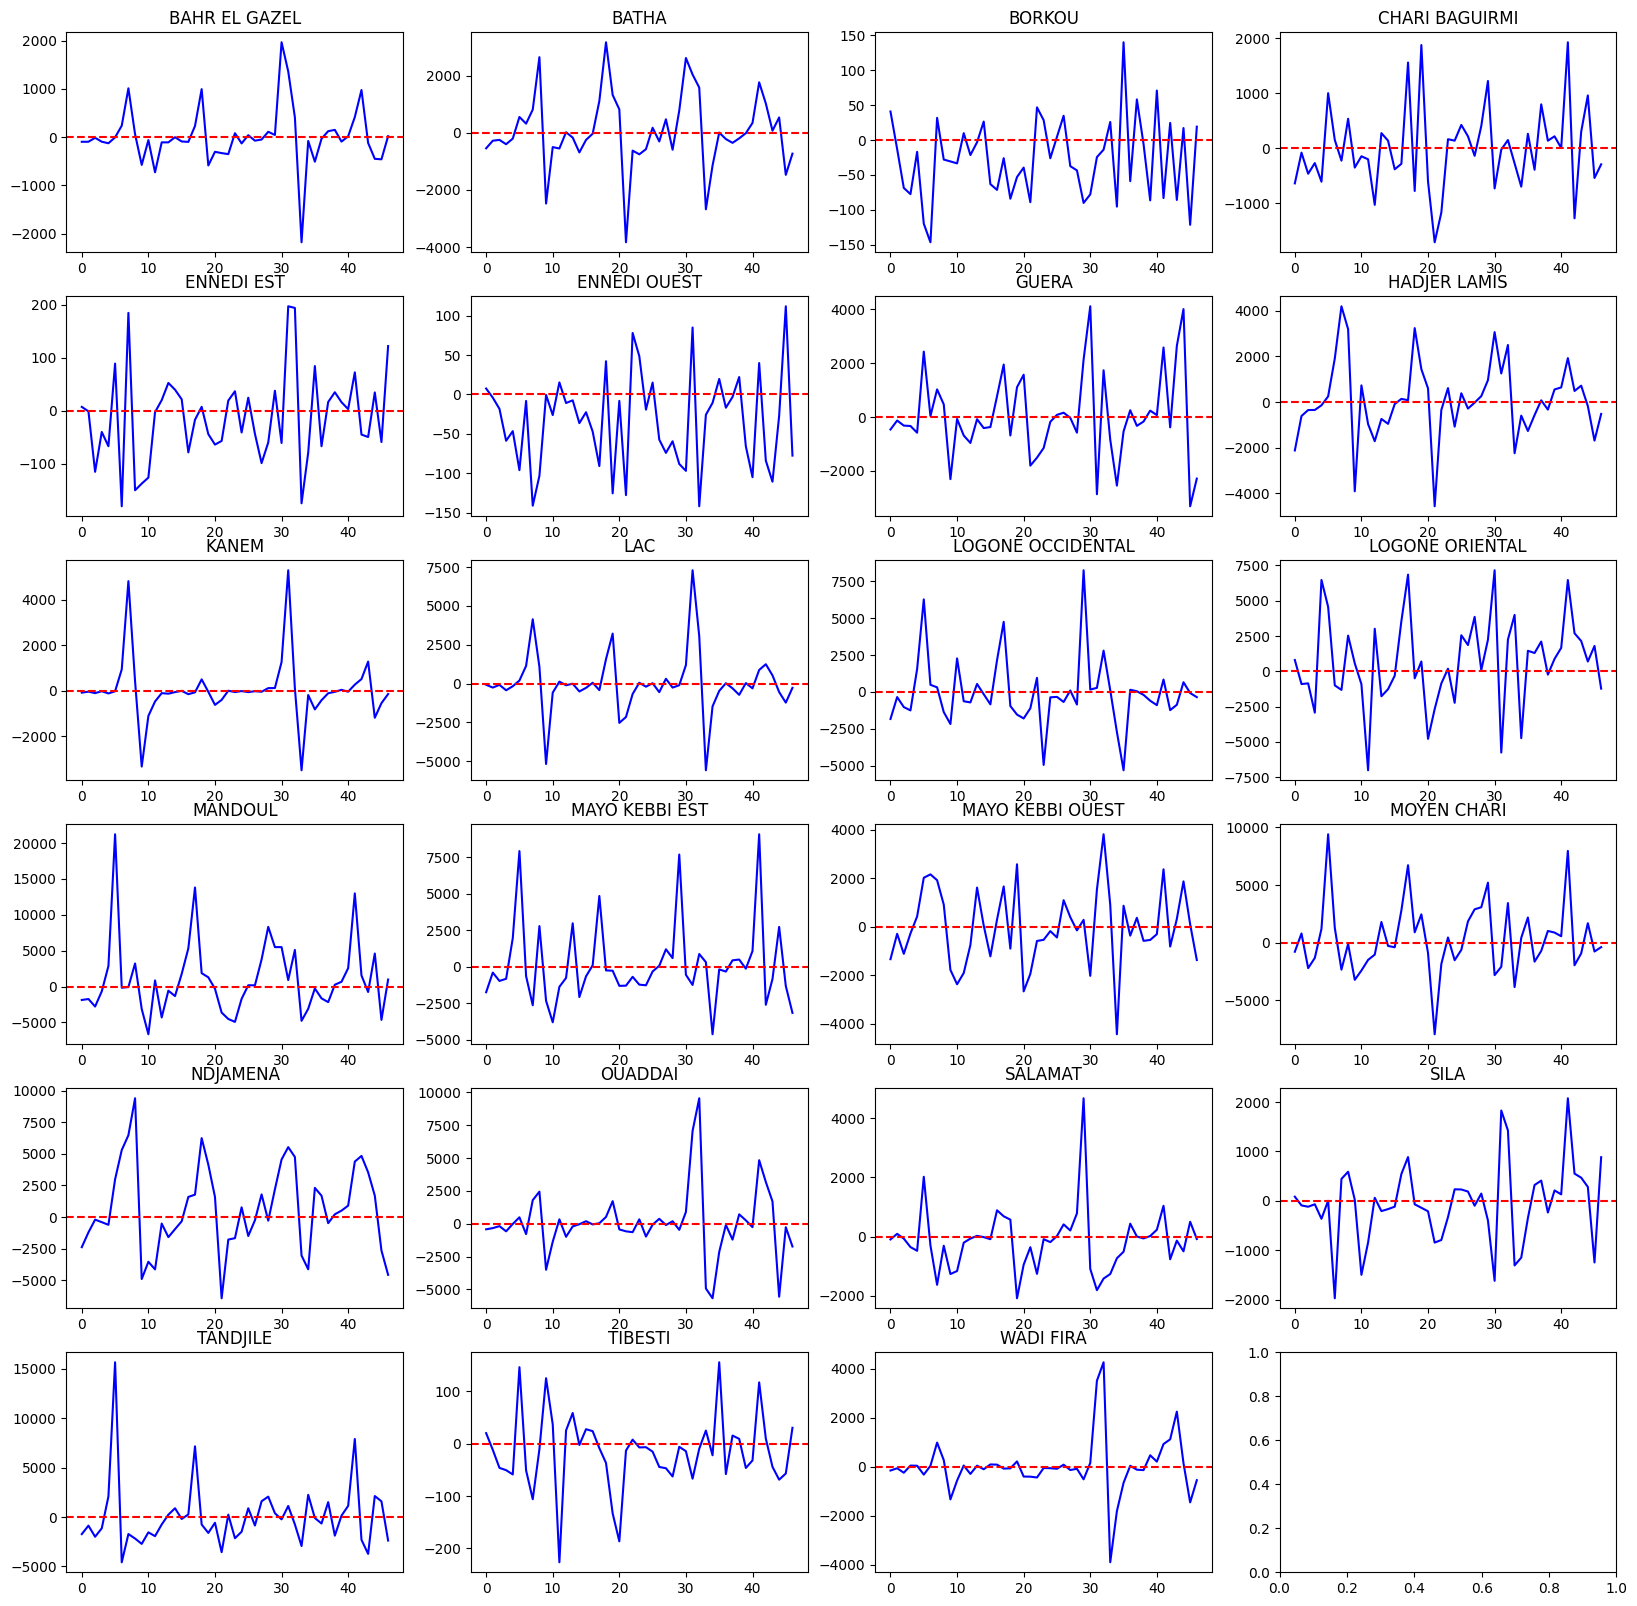

In [53]:
fig, axes = plt.subplots(6,4, figsize=(20,20))
xticks = range(47)
for i in range(23):
    idx = i // 4
    idy = i % 4
    mean_post_pred, hpdi_post_pred = predict(X[X[:,3+i]==1], mcmc, rng_key)
    axes[idx,idy].plot(y[X[:,3+i]==1]-mean_post_pred, label='Original', color='blue')
    axes[idx,idy].axhline(0, color='red', linestyle='--')
    axes[idx,idy].set_title(states[i])

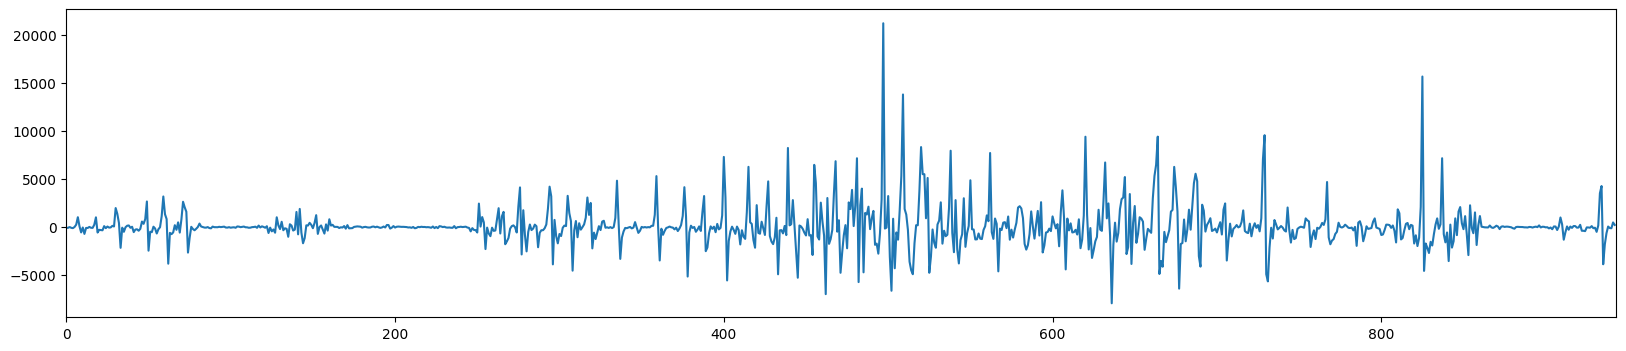

In [54]:
pred_mean, pred_hpdi = predict(X_train, mcmc, rng_key)

fig, ax = plt.subplots(1,1, figsize=(20,4))
ax.plot(y_train-pred_mean)
plt.savefig('../../docs/residual_train.png', bbox_inches='tight', pad_inches=0.0)
plt.xlim((0,len(pred_mean)))
plt.show()

## Evaluation metrics

In [111]:
# Posterior predictive
rng_key, rng_key_ = random.split(rng_key)
samples_1 = mcmc.get_samples()
predictive = Predictive(panel_model, samples_1)
posterior_predictions = predictive(rng_key_, X=X_test)
post_obs = posterior_predictions['obs']

mean_post_pred = round(jnp.mean(post_obs, axis=0))
hpdi_post_pred = hpdi(post_obs, 0.9)

In [112]:
rmse = jnp.sqrt(((y_test - mean_post_pred)**2).mean())
mae = jnp.abs(y_test - mean_post_pred).mean()

ss_total = jnp.var(y_test)
ss_residual = jnp.mean((y_test - mean_post_pred.round()) ** 2)
r_squared = 1 - (ss_residual / ss_total)

print('RMSE:', rmse)
print('MAE:', mae)
print(f'Bayesian R-squared: {r_squared}')

RMSE: 2416.6462
MAE: 1458.7609
Bayesian R-squared: 0.8718526363372803
